# Agentic RAG - Retrieval Augmented Generation use case for 🎩 Alfred

##### Import statements

In [1]:
from IPython.display import Image
import datasets
from langchain_core.documents import Document
from dotenv import load_dotenv, dotenv_values, find_dotenv
import os
from langchain_community.retrievers import BM25Retriever
from langchain_core.tools import Tool
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages
from langchain_core.messages import AnyMessage, HumanMessage, AIMessage
from langgraph.prebuilt import ToolNode
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace



## Very brief RAG recap

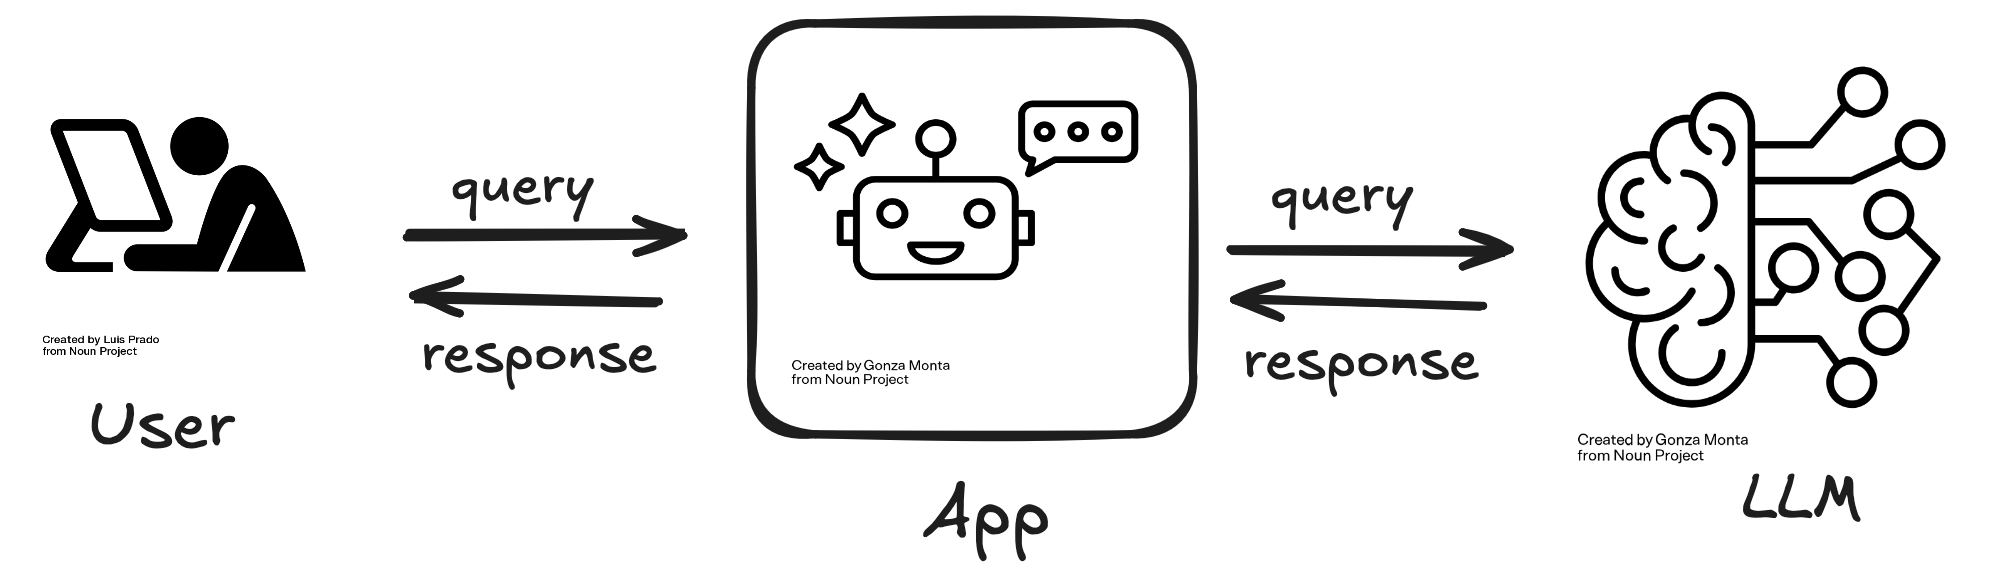

In [2]:
Image("images/non_rag.png")

In a non-RAG LLM application, the user sends a query to an LLM and receives a response.

In RAG we leverage the capabilities of the LLM while attempting to give it **additional, relevant information** for our use case, and to **prevent it from giving responses outside of this context**.

#### Additional Data
We have some data sources, which we store in a database.
A very common way to process this data is:
1. **chunking** -> larger texts are cut into some small subsets
2. **embedding** -> these chunks are not kept as plain text but rather embedded as semantic vectors
3. **vector database** -> an efficient way of storing embeddings (e.g. FAISS, Weaviate, etc)

The design decisions on chunk size, embedding model etc can affect the performance of the RAG application, and are use-case dependent

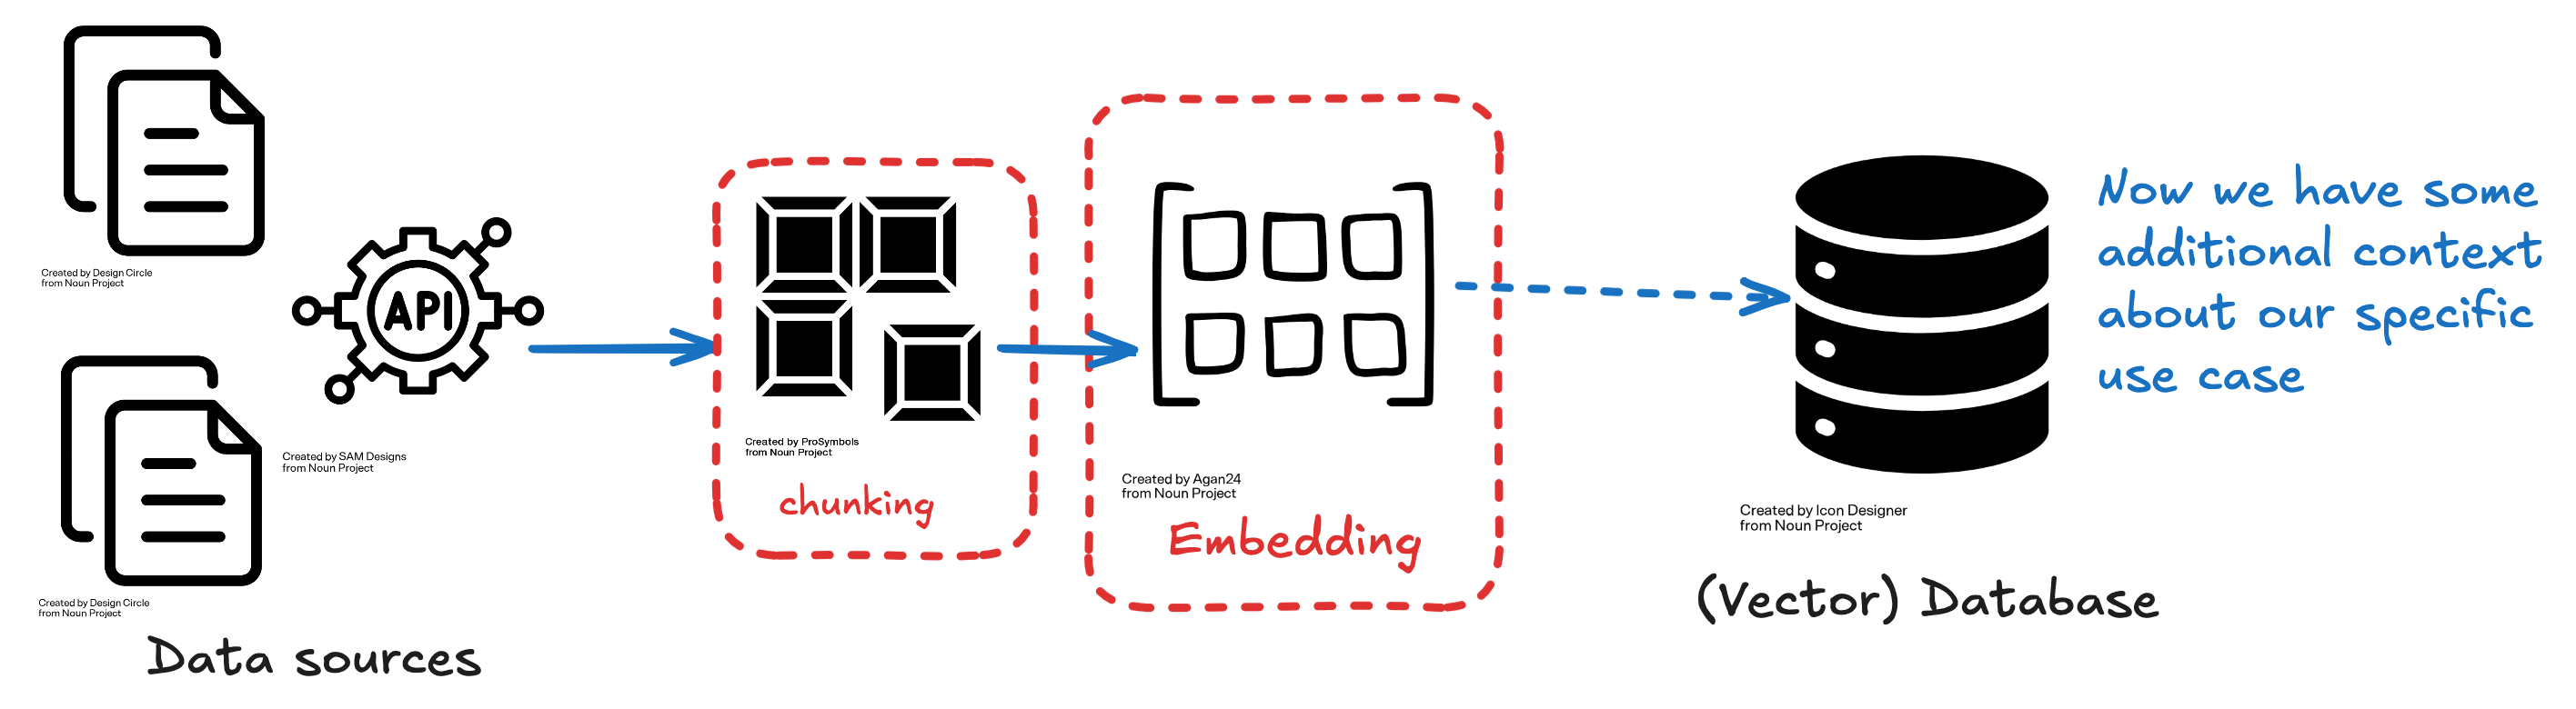

In [3]:
Image("images/data_embedding.png")

#### Retrieval: The ✨R✨ in RAG

In order to be able to use the information from the knowledge database, we need to search for it. 
In the Retrieval step, our application:
1. Takes the user query
2. Passes it through the same embedding model as the data
3. Checks the vector database for the most semantically similar vectors of the result
4. Returns those chunks of data (if present - if not, returns nothing)

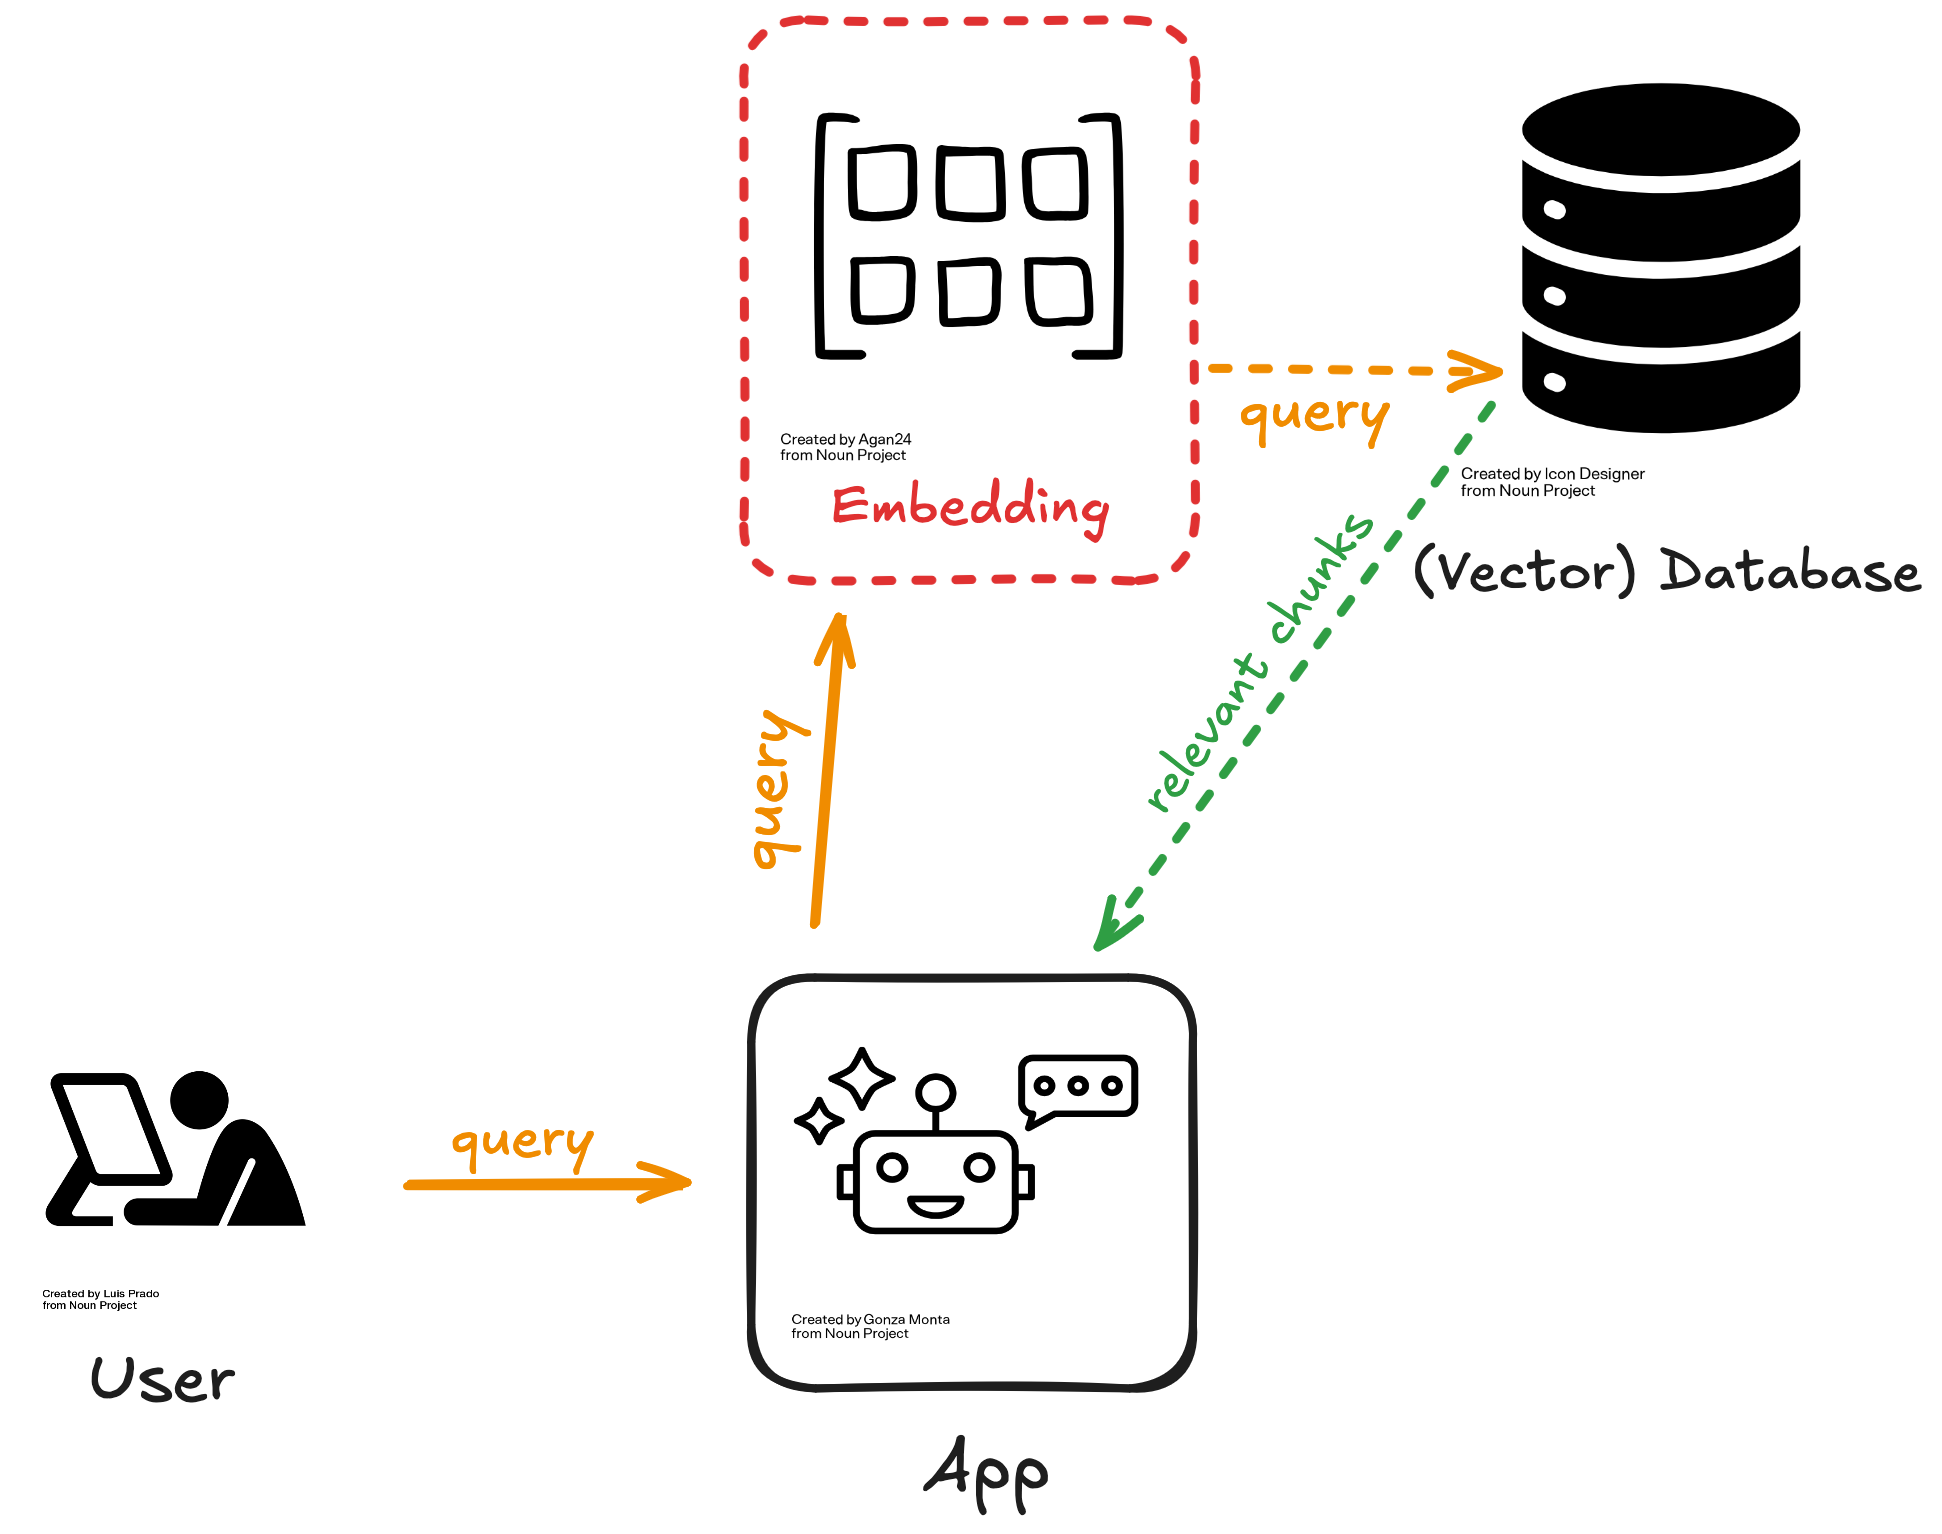

In [4]:
Image("images/retrieval_step.png")

#### Augmentation: the ✨A✨ in RAG

Now we have:
- our original query
- some semantically relevant additional info from our data

The next step is to combine them into a prompt for the LLM, which will give us **more specific, less irrelevant** responses

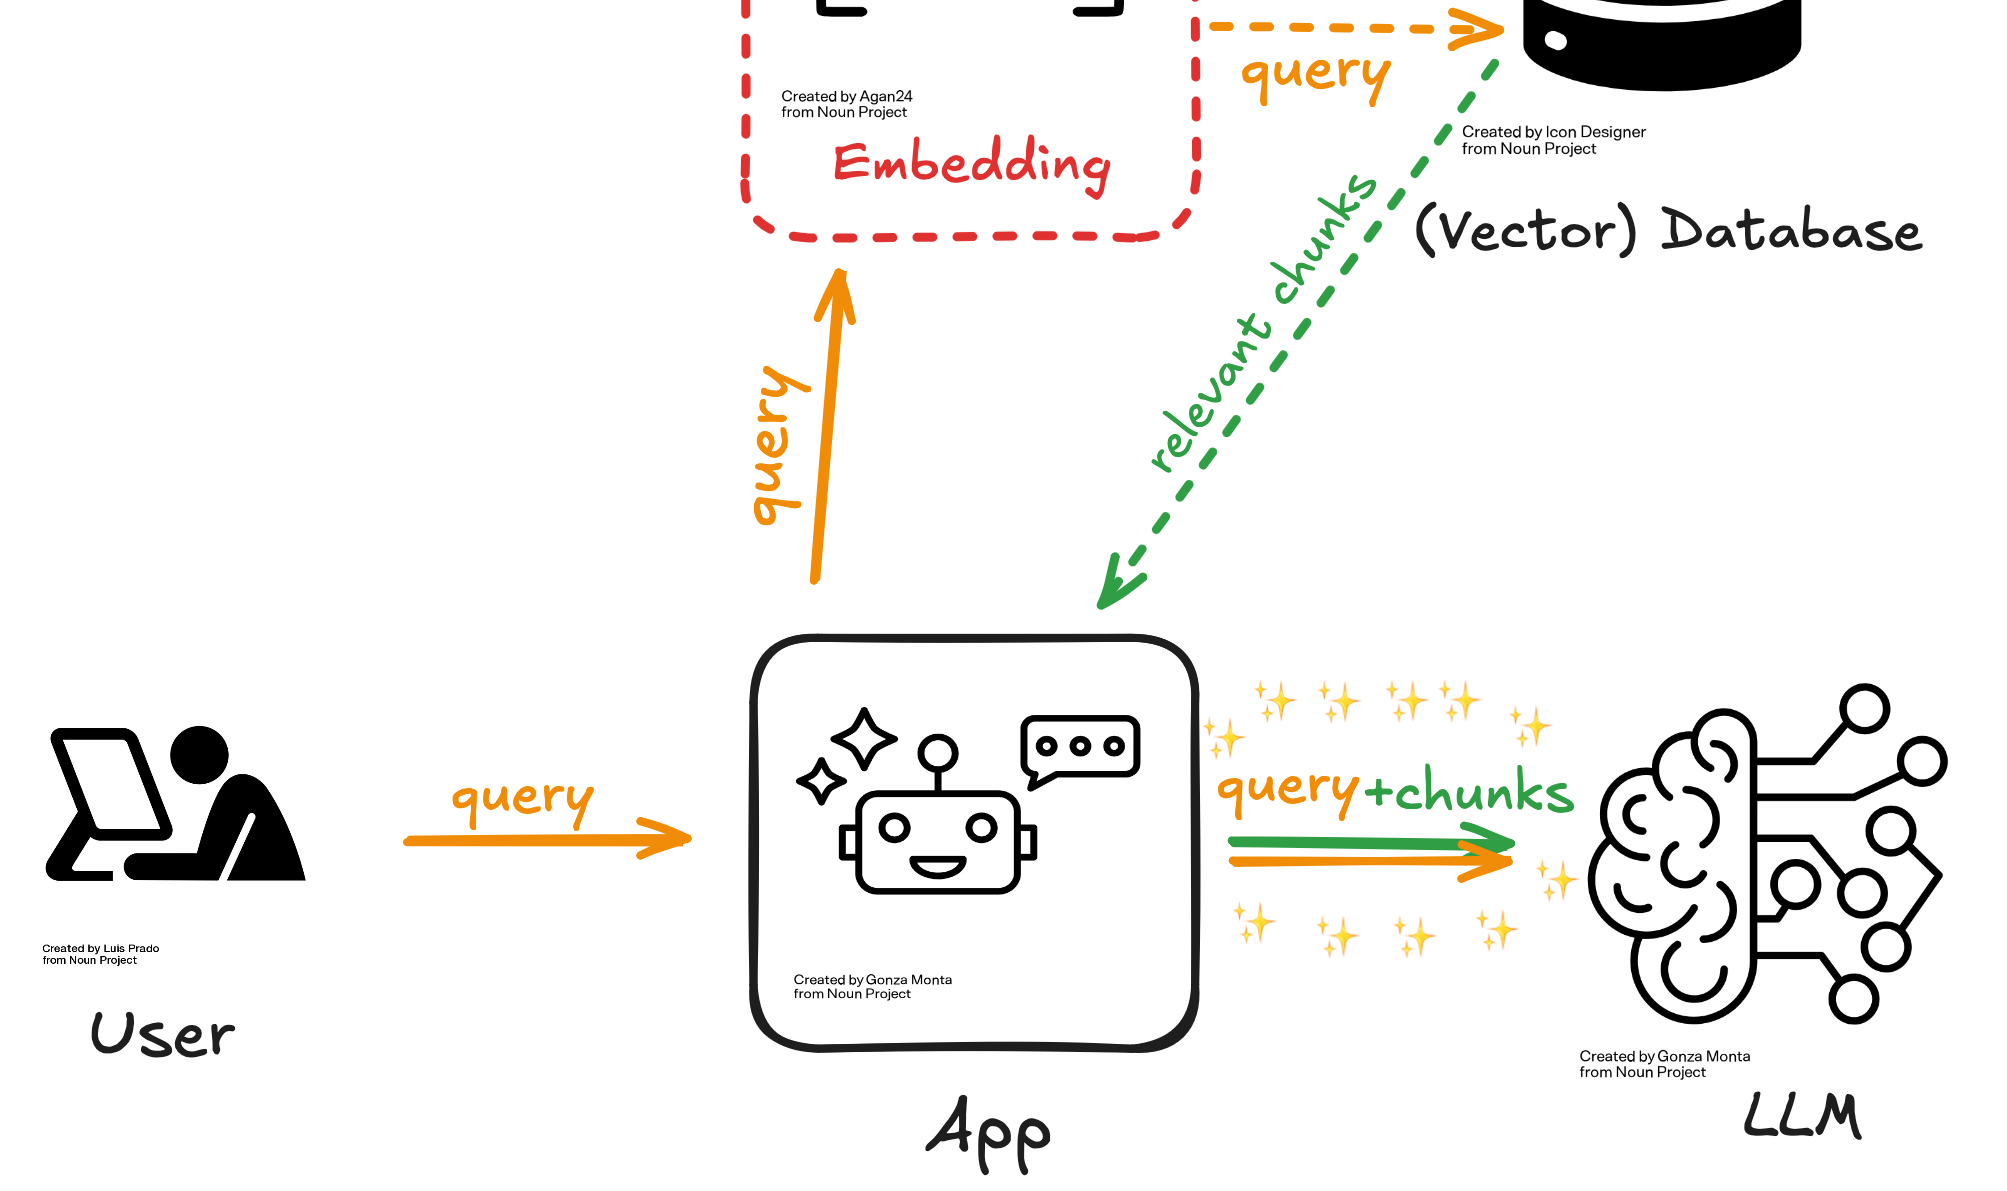

In [5]:
Image("images/augmentation_step.png")

#### Generation: the ✨G✨ in RAG

Now our LLM has a prompt sent to it which contains instructions to **only** give an answer if there are semantically relevant chunks present for our query. 

It can generate a response based on this, and this response can also be "I don't know" or "I do not have any information on this" or similar. 

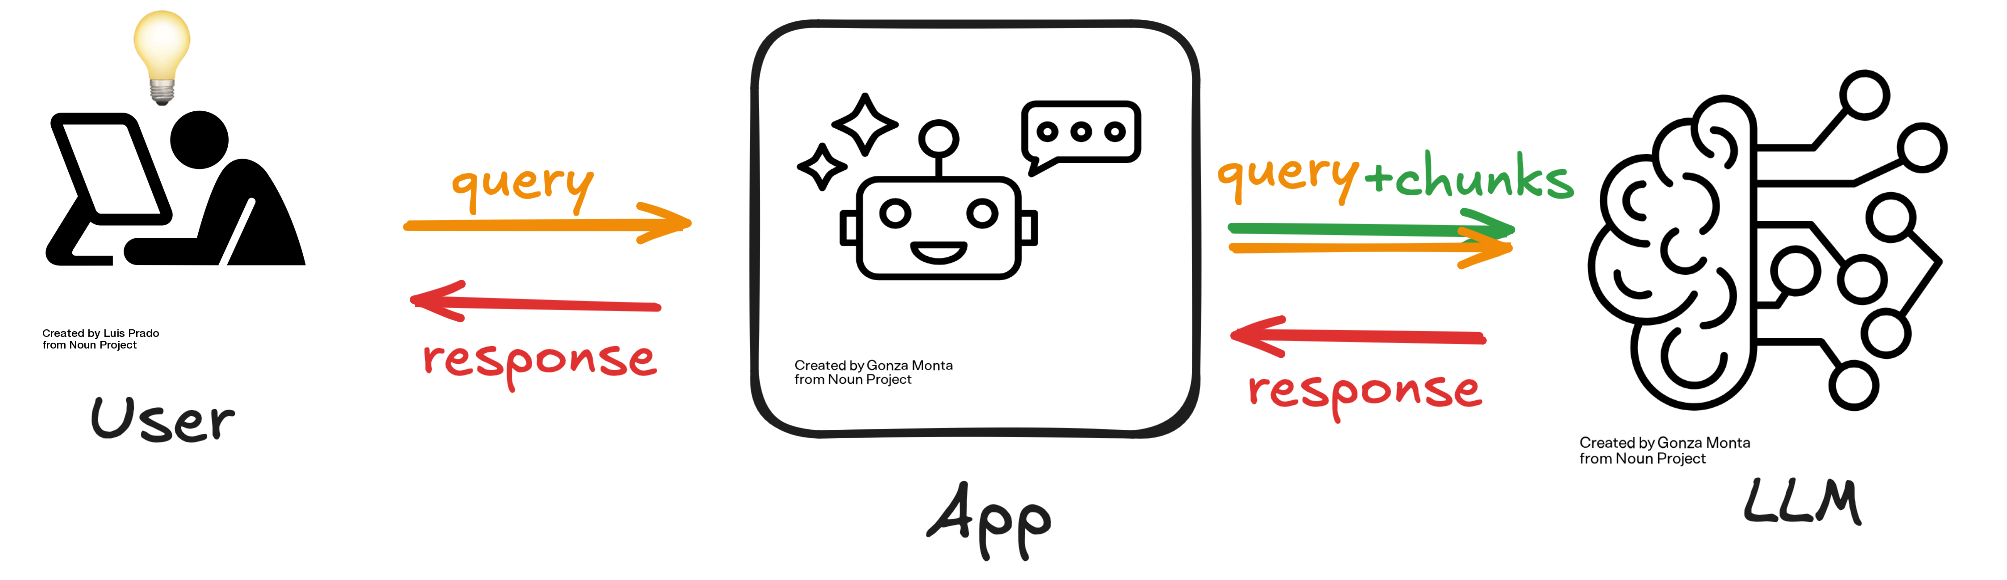

In [6]:
Image("images/generation_step.png")

#### Whole typical RAG flow summarised:


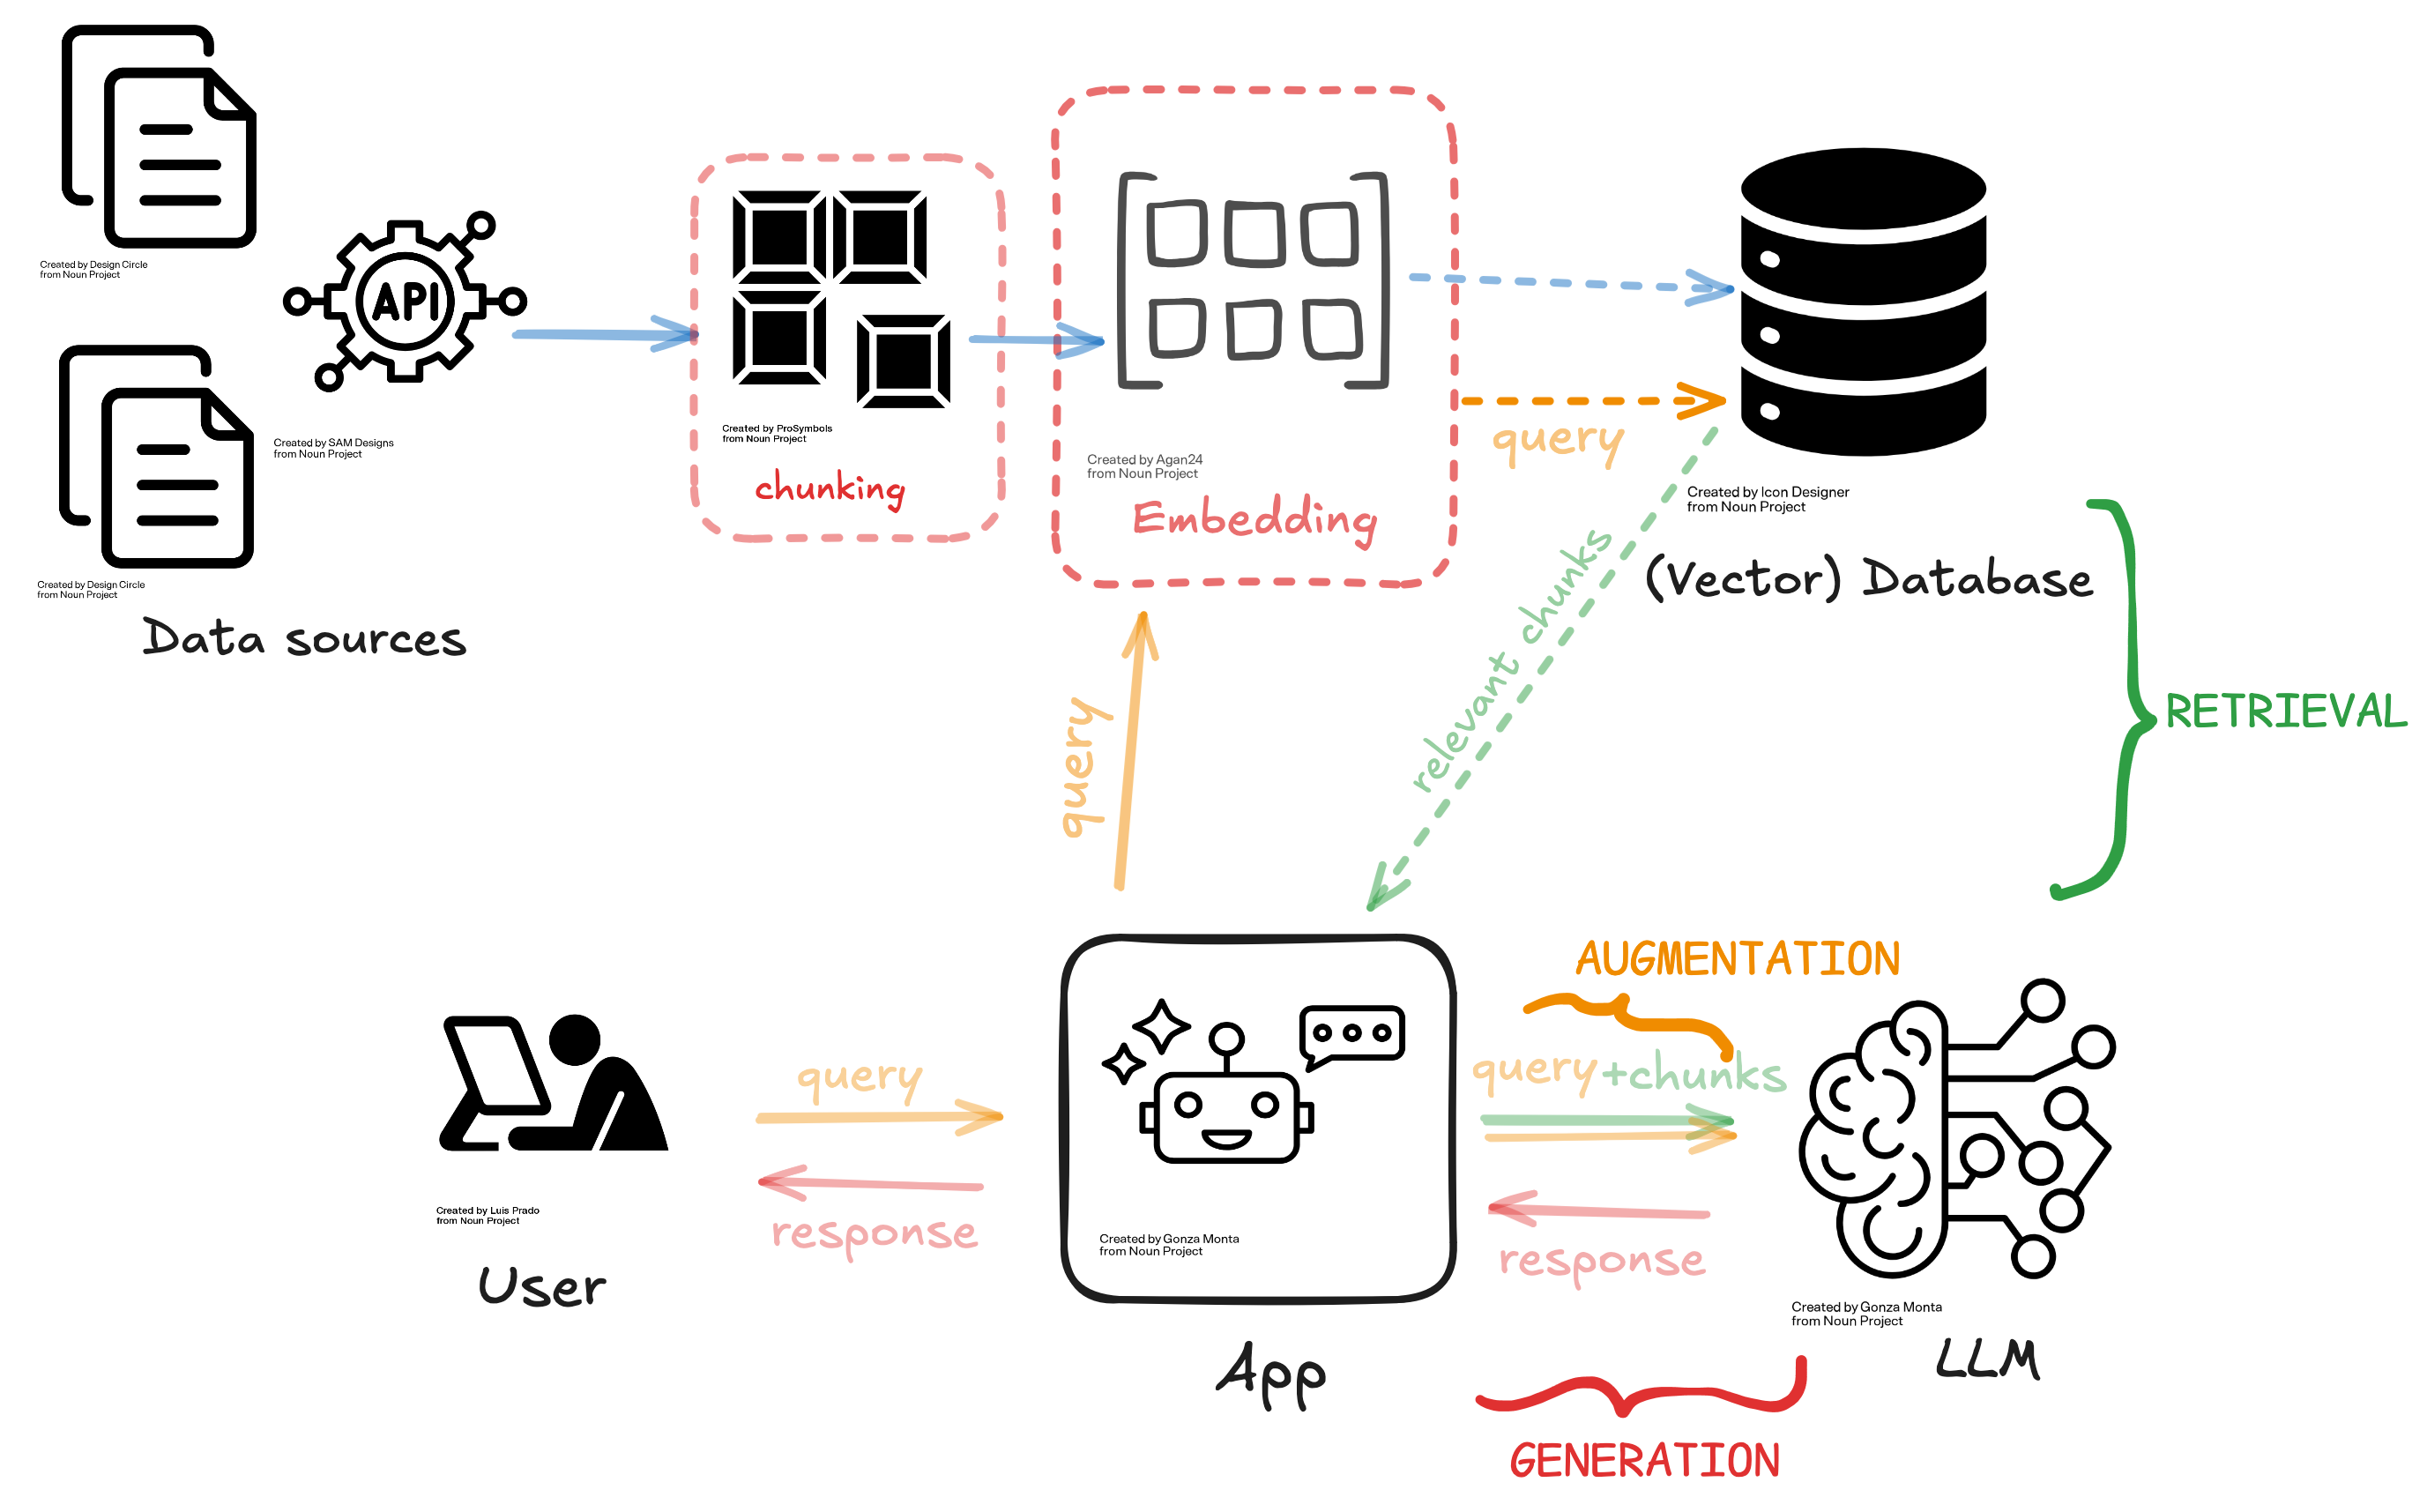

In [7]:
Image("images/whole_rag.png")

<font size="0.5">  
    Diagrams made using images from <a href="https://thenounproject.com">The Noun Project</a> 
    <ul>
     <li>computer user by Luis Prado from <a href="https://thenounproject.com/browse/icons/term/computer-user/" target="_blank" title="computer user Icons">Noun Project</a> (CC BY 3.0)</li>  
     <li>Chatbot by Gonza Monta from <a href="https://thenounproject.com/browse/icons/term/chatbot/" target="_blank" title="Chatbot Icons">Noun Project</a> (CC BY 3.0)</li>
     <li>brain circuit by Gonza Monta from <a href="https://thenounproject.com/browse/icons/term/brain-circuit/" target="_blank" title="brain circuit Icons">Noun Project</a> (CC BY 3.0)</li>
     <li>Files by Design Circle from <a href="https://thenounproject.com/browse/icons/term/files/" target="_blank" title="Files Icons">Noun Project</a> (CC BY 3.0)</li>
     <li>API by SAM Designs from <a href="https://thenounproject.com/browse/icons/term/api/" target="_blank" title="API Icons">Noun Project</a> (CC BY 3.0)</li>
     <li>matrix by Agan24 from <a href="https://thenounproject.com/browse/icons/term/matrix/" target="_blank" title="matrix Icons">Noun Project</a> (CC BY 3.0)</li>
     <li>chocolate chunks by ProSymbols from <a href="https://thenounproject.com/browse/icons/term/chocolate-chunks/" target="_blank" title="chocolate chunks Icons">Noun Project</a> (CC BY 3.0)</li>
     <li>database by Icon Designer from <a href="https://thenounproject.com/browse/icons/term/database/" target="_blank" title="database Icons">Noun Project</a> (CC BY 3.0)</li>
    </ul>
</font> 

#### In Alfred's case - BM25


**NB.** The suggested retriever tool in the tutorial does **not** use embeddings, and rather starts off with a tool called BM25 (Best Match 25)
- [here](https://watercrawl.dev/blog/Building-on-RAG) is a blog post explaining how both work and compating them
- it uses a scoring based on IDF, and term frequencies
- it is good for keyword searching, when e.g. exact product names or person names are relevant
- it ranks documents based on the score and returns the top matches
- see also [here](https://medium.com/@yashwanths_29644/retrieval-augmented-generation-rag-06-bm25-retriever-when-and-why-to-use-it-with-code-demo-132ed70c6bfd)

At the bottom of this notebook there is a small example for how to use embeddings and FAISS vector store from facebook instead, though with such a small dataset the differences are not so clear

## Agentic RAG

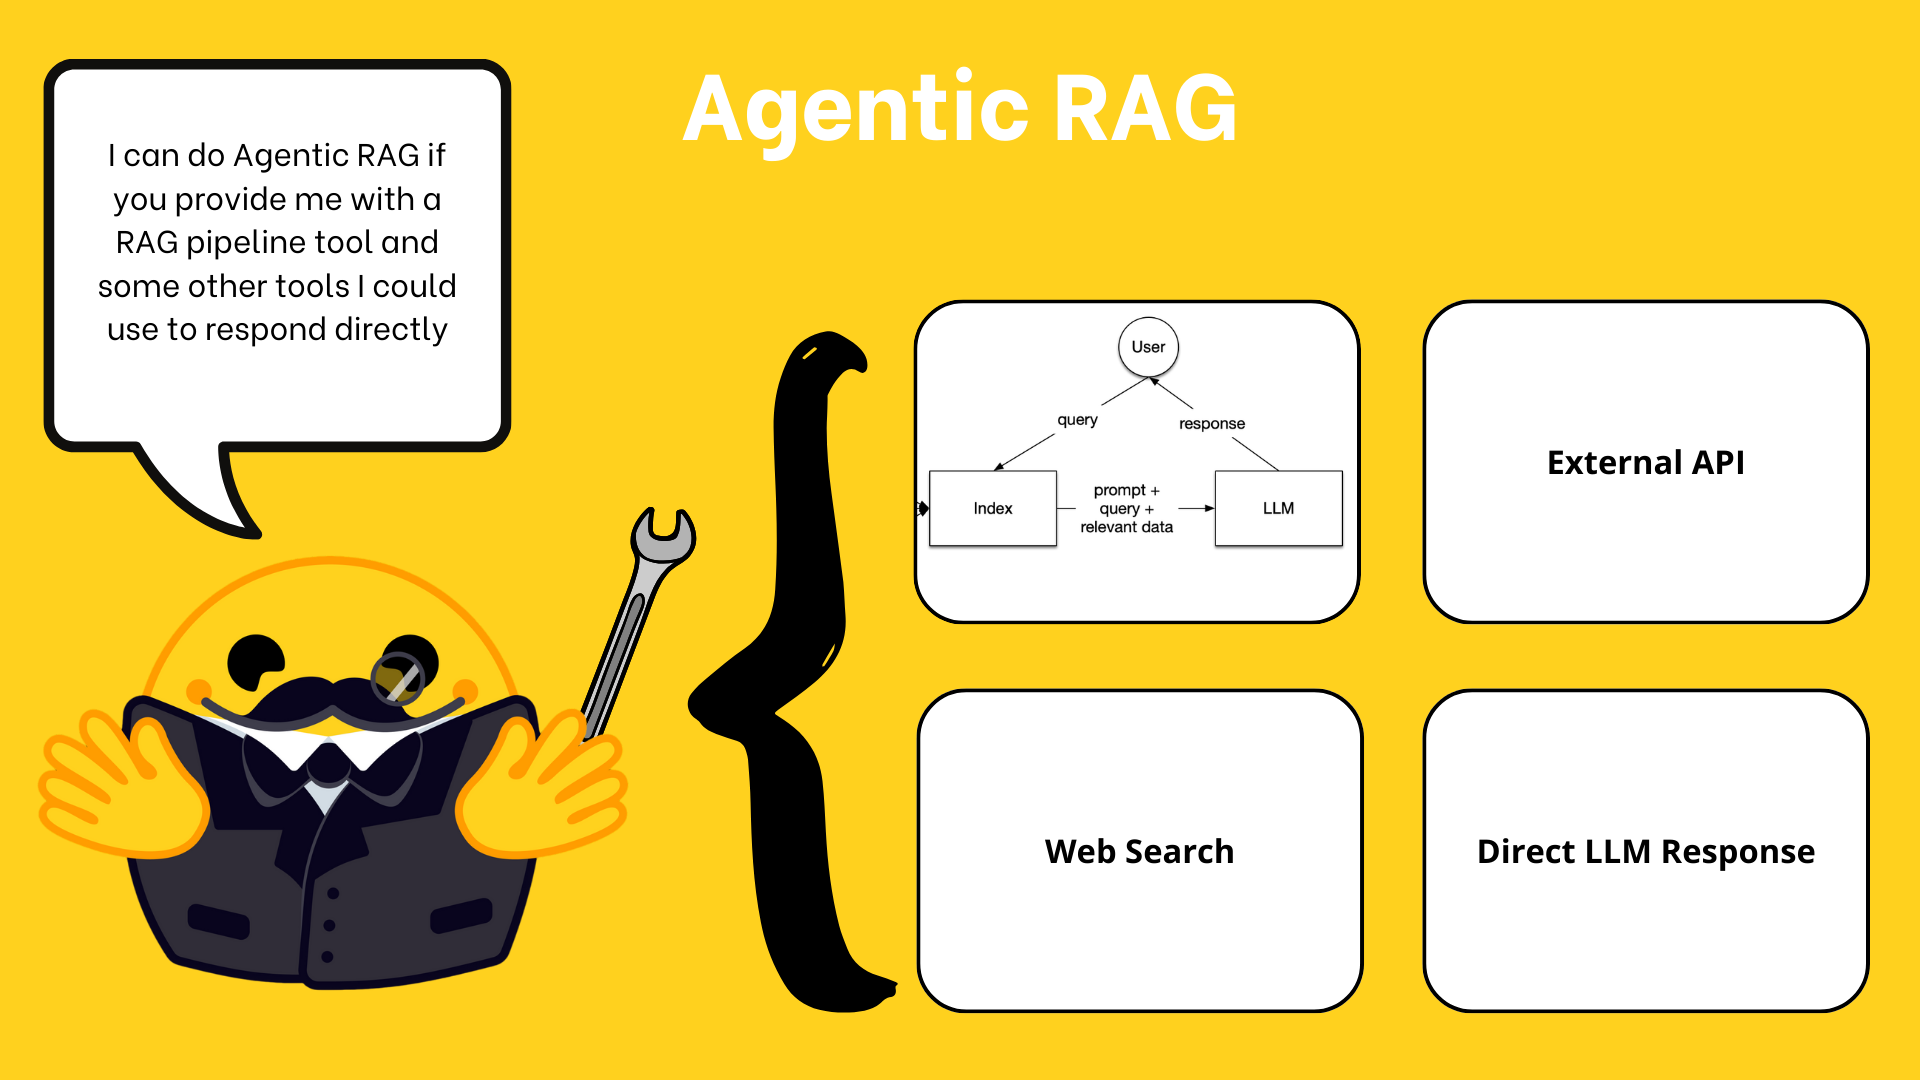

In [8]:
Image("https://huggingface.co/datasets/agents-course/course-images/resolve/main/en/unit2/llama-index/agentic-rag.png")

Source: HuggingFace [tutorial](https://huggingface.co/learn/agents-course/en/unit3/agentic-rag/agentic-rag)

In the given example, we are now not only building a RAG tool in and of itself, but rather giving it to our Agent as **one of the possible options** to solve a particular task, but not limiting the responses of the agent to outputs from the RAG system only

## Basic Tutorial workflow

In [ ]:
load_dotenv(find_dotenv())# reads variables from a .env file and sets them in os.environ
HUGGINGFACEHUB_API_TOKEN = os.getenv('HUGGINGFACEHUB_API_TOKEN')


### Loading dataset

See [here](https://huggingface.co/docs/datasets/en/loading) for documentation

In [ ]:
# Load the dataset
guest_dataset = datasets.load_dataset("agents-course/unit3-invitees", split="train")

# Convert dataset entries into Document objects
docs = [
    Document(
        page_content="\n".join([
            f"Name: {guest['name']}",
            f"Relation: {guest['relation']}",
            f"Description: {guest['description']}",
            f"Email: {guest['email']}"
        ]),
        metadata={"name": guest["name"]}
    )
    for guest in guest_dataset
]

### Creating Retriever tool

Doumentation [here](https://docs.langchain.com/oss/python/integrations/retrievers/bm25)

In [ ]:
bm25_retriever = BM25Retriever.from_documents(docs)

def extract_text(query: str) -> str:
    """Retrieves detailed information about gala guests based on their name or relation."""
    results = bm25_retriever.invoke(query)
    if results:
        return "\n\n".join([doc.page_content for doc in results[:3]])
    else:
        return "No matching guest information found."

guest_info_tool = Tool(
    name="guest_info_retriever",
    func=extract_text,
    description="Retrieves detailed information about gala guests based on their name or relation."
)

### Chat interface

In [ ]:
# Generate the chat interface, including the tools
llm = HuggingFaceEndpoint(
    repo_id="Qwen/Qwen3-Coder-Next", #model in materials didn't work, newer one does
    huggingfacehub_api_token=HUGGINGFACEHUB_API_TOKEN,
)

chat = ChatHuggingFace(llm=llm, verbose=True)
tools = [guest_info_tool]
chat_with_tools = chat.bind_tools(tools)

# Generate the AgentState and Agent graph
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

def assistant(state: AgentState):
    return {
        "messages": [chat_with_tools.invoke(state["messages"])],
    }

## The graph
builder = StateGraph(AgentState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message requires a tool, route to tools
    # Otherwise, provide a direct response
    tools_condition,
)
builder.add_edge("tools", "assistant")
alfred = builder.compile()

#### Experiment 1: retrieving information about a specific guest

In [ ]:
#my_input = "who is Ada Lovelace?"
#my_input = "how do I contact Ada Lovelace?"  #50/50
#my_input = "what is Ada Lovelace's phone number?"
#my_input = "Wer ist Ada Lovlac?"


In [ ]:
messages = [HumanMessage(content=my_input)]
response = alfred.invoke({"messages": messages})

print("🎩 Alfred's Response:")
print(response['messages'][-1].content)

#### Experiment 2: retrieving information about a specific guest, not by name

In [ ]:
#my_input = "what is the name of my inventor guest?"
#my_input = "who of the people coming today is a physicist?"
#my_input = "is the first programmer coming today? how do I know them?"
#my_input = "what is the phone number of my gala guest who loves pigeons?"

In [ ]:
messages = [HumanMessage(content=my_input)]
response = alfred.invoke({"messages": messages})

print("🎩 Alfred's Response:")
print(response['messages'][-1].content)

#### Experiment 2.5 - asking collective information about the guests

In [ ]:
my_input = "how many people are coming today?"
#my_input = "how many people are coming to the gala?"
#my_input = "can you please tell me a fun fact about each guest at the gala?"
#my_input = "can you tell me how women are guests of the gala?"
#my_input = "there are no physicists coming to the gala, is that correct?"
#my_input = "there are no physicists coming to the gala, is that correct? please check the attendees list and let me know"


In [ ]:
messages = [HumanMessage(content=my_input)]
response = alfred.invoke({"messages": messages})

print("🎩 Alfred's Response:")
print(response['messages'][-1].content)

#### Experiment 3: mixing RAG context with general knowledge of LLM

In [ ]:
#my_input = "what would be a good gift for Nikola Tesla?" #50/50
#my_input = "what would be a good gift for Nikola Tesla based on what you know about him from the gala guest information?"
#my_input = "what is my guest Nikola Tesla's phone number? What would be a good pigeon breed to gift him?"
#my_input = "What are the best pigeon breeds to give as a gift to Nikola Tesla? what is his phone number?"

In [ ]:
messages = [HumanMessage(content=my_input)]
response = alfred.invoke({"messages": messages})

print("🎩 Alfred's Response:")
print(response['messages'][-1].content)

#### Experiment 4: Adding more messages to Alfred

In [ ]:
my_input = "what would be a good gift for Nikola Tesla?" #50/50


In [ ]:
messages = [HumanMessage(content=my_input)]
response = alfred.invoke({"messages": messages})

print("🎩 Alfred's Response:")
print(response['messages'][-1].content)

## Adding Web Search

In [ ]:
from langchain_community.tools import DuckDuckGoSearchRun

search_tool = DuckDuckGoSearchRun()

In [ ]:
my_query = "when is BVG next striking in Berlin?"

In [ ]:
# try re-running this cell with the same query! 
results = search_tool.invoke(my_query)
print(results)

## Adding fake weather data

In [ ]:
from langchain_core.tools import Tool
import random

def get_weather_info(location: str) -> str:
    """Fetches dummy weather information for a given location."""
    # Dummy weather data
    weather_conditions = [
        {"condition": "Rainy", "temp_c": 15},
        {"condition": "Clear", "temp_c": 25},
        {"condition": "Windy", "temp_c": 20}
    ]
    # Randomly select a weather condition
    data = random.choice(weather_conditions)
    return f"Weather in {location}: {data['condition']}, {data['temp_c']}°C"

# Initialize the tool
weather_info_tool = Tool(
    name="get_weather_info",
    func=get_weather_info,
    description="Fetches dummy weather information for a given location."
)

In [ ]:
# Generate the chat interface, including the tools
llm = HuggingFaceEndpoint(
    repo_id="Qwen/Qwen3-Coder-Next", #model in materials didn't work, newer one does
    huggingfacehub_api_token=HUGGINGFACEHUB_API_TOKEN,
)

chat = ChatHuggingFace(llm=llm, verbose=True)
tools = [weather_info_tool
        ,guest_info_tool
        ]
chat_with_tools = chat.bind_tools(tools)

# Generate the AgentState and Agent graph
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

def assistant(state: AgentState):
    return {
        "messages": [chat_with_tools.invoke(state["messages"])],
    }

## The graph
builder = StateGraph(AgentState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message requires a tool, route to tools
    # Otherwise, provide a direct response
    tools_condition,
)
builder.add_edge("tools", "assistant")
alfred = builder.compile()

In [ ]:
# Try re-running these:
#my_input = "what is the weather like in Paris today?"
#my_input = "what is the weather like in Marie Curie's hometown today?"
#my_input = "what is the email address of Nikola Tesla?"
#my_input = "what is the email address of my gala guest Nikola Tesla?"
#my_input = "what is the email address of Nikola Tesla? what is the weather in his hometown? what is his home town"
#my_input = "is today's weather suitable for pigeon racing? would any of my guests be interested?"

In [ ]:
messages = [HumanMessage(content=my_input)]
response = alfred.invoke({"messages": messages})

print("🎩 Alfred's Response:")
print(response['messages'][-1].content)

## Adding HuggingFace Stats

In [ ]:
from langchain_core.tools import Tool
from huggingface_hub import list_models

def get_hub_stats(author: str) -> str:
    """Fetches the most downloaded model from a specific author on the Hugging Face Hub."""
    try:
        # List models from the specified author, sorted by downloads
        models = list(list_models(author=author, sort="downloads", direction=-1, limit=1))

        if models:
            model = models[0]
            return f"The most downloaded model by {author} is {model.id} with {model.downloads:,} downloads."
        else:
            return f"No models found for author {author}."
    except Exception as e:
        return f"Error fetching models for {author}: {str(e)}"

# Initialize the tool
hub_stats_tool = Tool(
    name="get_hub_stats",
    func=get_hub_stats,
    description="Fetches the most downloaded model from a specific author on the Hugging Face Hub."
)

In [ ]:
# Example usage
my_input = "facebook"
#my_input = "Facebook"
print(hub_stats_tool.invoke(my_input)) # Example: Get the most downloaded model by Facebook

**To do:** figure out a way to implement typos / case insensitive model search

### Combining all the tools

In [ ]:
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages
from langchain_core.messages import AnyMessage, HumanMessage, AIMessage
from langgraph.prebuilt import ToolNode
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace

# Generate the chat interface, including the tools
llm = HuggingFaceEndpoint(
    repo_id="Qwen/Qwen3-Coder-Next",
    huggingfacehub_api_token=HUGGINGFACEHUB_API_TOKEN,
)

chat = ChatHuggingFace(llm=llm, verbose=True)
tools = [guest_info_tool,
        search_tool,
         weather_info_tool,
         hub_stats_tool
        ]
chat_with_tools = chat.bind_tools(tools)

# Generate the AgentState and Agent graph
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

def assistant(state: AgentState):
    return {
        "messages": [chat_with_tools.invoke(state["messages"])],
    }

## The graph
builder = StateGraph(AgentState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message requires a tool, route to tools
    # Otherwise, provide a direct response
    tools_condition,
)
builder.add_edge("tools", "assistant")
alfred = builder.compile()

In [ ]:
my_input = "Who is Facebook and what's their most popular model on huggingface?"

In [ ]:
messages = [HumanMessage(content=my_input)]
response = alfred.invoke({"messages": messages})

print("🎩 Alfred's Response:")
print(response['messages'][-1].content)

#### Experiment 1: Combining RAG and other tools

In [ ]:
# uncomment guest info and re-initialise alfred for this - all tools on
#my_input = "Who is Facebook and what's their most popular model on huggingface?"

In [ ]:
# try with and without web search
#my_input = "what is the contact information for Marie Curie?"
#my_input = "what is the contact information for my gala guest Marie Curie based on your guest information?"

In [ ]:
# try with and without web search
#my_input = "what is Nikola Tesla's phone number and how do I know him?"
#my_input = "what is my gala guest's Nikola Tesla's phone number and how do I know him?"
#my_input = "where was Nikola Tesla born? what is his phone number and how do I know him?"
#my_input = "where was Nikola Tesla, my gala guest, born? what is his phone number and how do I know him?"
#my_input = "when is the next solar eclipse? where was Nikola Tesla born? how can I contact him?"
#my_input = "when is the next solar eclipse? what is the weather in Nikola Tesla's hometown? how can I contact Marie Curie?"

In [ ]:
messages = [HumanMessage(content=my_input)]
response = alfred.invoke({"messages": messages})

print("🎩 Alfred's Response:")
print(response['messages'][-1].content)

## Some open questions + experiments

### Does using embeddings change anything? 

In [ ]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_community.vectorstores.faiss import DistanceStrategy


### Classic RAG tool with vector store

Steps taken mostly from [here](https://docs.langchain.com/oss/python/langchain/rag#overview)

#### Our chat model

In [ ]:
# Generate the chat interface, including the tools
llm = HuggingFaceEndpoint(
    repo_id="Qwen/Qwen3-Coder-Next", #model in materials didn't work, newer one does
    huggingfacehub_api_token=HUGGINGFACEHUB_API_TOKEN,
)

chat = ChatHuggingFace(llm=llm, verbose=True)

#### 1. Create Vector Store

In [ ]:
def create_embedding_vector_db(chunks, db_name):
    """
    This function uses the open-source embedding model HuggingFaceEmbeddings 
    to create embeddings and store those in a VectorStore called FAISS, 
    which allows for efficient similarity search
    """
    # instantiate embedding model
    embedding = HuggingFaceEmbeddings(
        model_name='sentence-transformers/all-mpnet-base-v2',
        encode_kwargs={"normalize_embeddings": True} #this is important if using Cosine Similarity
    )

    # create the vector store 
    vectorstore = FAISS.from_documents(
        documents=chunks,
        embedding=embedding,
        distance_strategy=DistanceStrategy.COSINE, # or DistanceStrategy.DOT or DistanceStrategy.L2 
    )
    # save VectorStore locally
    vectorstore.save_local(f"./vector_databases/vector_db_{db_name}")
    return vectorstore


#### 2. Create a Text Splitter (chunking)

In [ ]:
# Text splitter

from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,  # chunk size (characters) #FEEL FREE TO PLAY AROUND WITH THIS
    chunk_overlap=100,  # chunk overlap (characters) #FEEL FREE TO PLAY AROUND WITH THIS
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split guest info into {len(all_splits)} sub-documents.")

#### 3. Process the text and store it in the Vector DB

In [ ]:
all_embeddings=create_embedding_vector_db(chunks=all_splits, db_name="guests")

#### 4. Create a Retrieval Tool

In [ ]:
def retrieve_from_vector_db(vector_db_path):
    """
    this function splits out a retriever object from a local VectorStore
    """
    # instantiate embedding model
    # NEEDS TO BE THE SAME ONE AS FOR DATA
    embeddings = HuggingFaceEmbeddings(
        model_name='sentence-transformers/all-mpnet-base-v2',
        encode_kwargs={"normalize_embeddings": True}
    )
    loaded_vectorstore = FAISS.load_local(
        folder_path=vector_db_path,
        embeddings=embeddings,
        allow_dangerous_deserialization=True,
        distance_strategy=DistanceStrategy.COSINE  # or DistanceStrategy.DOT or DistanceStrategy.L2 
    )
    retriever = loaded_vectorstore.as_retriever()
    return retriever, loaded_vectorstore

# Load the retriever and index
guest_retriever,guest_vectorstore = retrieve_from_vector_db("./vector_databases/vector_db_guests")


In [ ]:
query= "what was Tesla's favourite animal?"
guest_retriever.invoke(query,k=5)

In [ ]:
def retrieve_info(query: str) -> str:
    """Retrieves detailed information about gala guests based on their name or relation."""
    results = guest_retriever.invoke(query)
    if results:
        return "\n\n".join([doc.page_content for doc in results[:3]])
    else:
        return "No matching guest information found."

guest_info_tool_faiss = Tool(
    name="guest_info_retriever",
    func=retrieve_info,
    description="Retrieves detailed information about gala guests based on their name or relation."
)

#### Generate chat interface

In [ ]:
# Generate the chat interface, including the tools
llm = HuggingFaceEndpoint(
    repo_id="Qwen/Qwen3-Coder-Next",
    huggingfacehub_api_token=HUGGINGFACEHUB_API_TOKEN,
)

chat = ChatHuggingFace(llm=llm, verbose=True)
tools = [guest_info_tool_faiss]
chat_with_tools = chat.bind_tools(tools)

# Generate the AgentState and Agent graph
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

def assistant(state: AgentState):
    return {
        "messages": [chat_with_tools.invoke(state["messages"])],
    }

## The graph
builder = StateGraph(AgentState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message requires a tool, route to tools
    # Otherwise, provide a direct response
    tools_condition,
)
builder.add_edge("tools", "assistant")
alfred = builder.compile()

In [ ]:
#my_input = "what is Marie Curie's phone number?"
#my_input = "what is my friend Marie Curie's phone number?"
my_input = "what is Nikola Tesla's favourite kind of bird?" #50-50
#my_input = "what was my old friend Nikola Tesla's favourite kind of bird?"

In [ ]:
messages = [HumanMessage(content=my_input)]
response = alfred.invoke({"messages": messages})

print("🎩 Alfred's Response:")
print(response['messages'][-1].content)

**NB** This is an agent only using the RAG tool and the base LLM, we can also add the other tools to it, as above :)  

### Open questions: 
- Can we make Alfred prioritise RAG results over internet search? 
- Does adding a system message change our outcome? 